# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import backend as K

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

Using TensorFlow backend.


In [2]:
data=np.load("images.npy",allow_pickle=True)

In [3]:
print(data.shape)

(409, 2)


- There are 409 images in the given dataset.

### Check one sample from the loaded "images.npy" file  (3 marks)
- Hint: print data[10][1] 

In [4]:
print(data[20][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.4979166666666667, 'y': 0.20833333333333334}, {'x': 0.7854166666666667, 'y': 0.6888888888888889}], 'imageWidth': 480, 'imageHeight': 360}]


### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [5]:
ALPHA = 1
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [6]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]),  HEIGHT_CELLS,WIDTH_CELLS))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * 28)
        x2 = int(i["points"][1]['x'] * 28)
        y1 = int(i["points"][0]['y'] * 28)
        y2 = int(i["points"][1]['y'] * 28)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (3 marks)
- 400 images in training
- 9 images in testing data

Training data

In [7]:
X_train = X[:-9]
y_train = masks[:-9]

In [8]:
print(X_train.shape)
print(y_train.shape)

(400, 224, 224, 3)
(400, 28, 28)


Testing data

In [9]:
X_test = X[400:]
y_test = masks[400:]

In [10]:
print(X_test.shape)
print(y_test.shape)

(9, 224, 224, 3)
(9, 28, 28)


### Print a sample training image, image array and its mask (3 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.5529412  -0.69411767 -0.75686276]
  [-0.56078434 -0.7019608  -0.78039217]
  [-0.57647061 -0.71764708 -0.81176472]
  ...
  [ 0.25490201  0.12156868 -0.09803921]
  [ 0.26274514  0.12156868 -0.12156862]
  [ 0.29411769  0.14509809 -0.11372548]]

 [[-0.65490198 -0.80392158 -0.86666667]
  [-0.67843139 -0.81960785 -0.89803922]
  [-0.69411767 -0.83529413 -0.92941177]
  ...
  [ 0.19215691  0.06666672 -0.1607843 ]
  [ 0.21568632  0.06666672 -0.17647058]
  [ 0.26274514  0.11372554 -0.14509803]]

 [[-0.67058825 -0.81960785 -0.87450981]
  [-0.69411767 -0.83529413 -0.9137255 ]
  [-0.70980394 -0.8509804  -0.94509804]
  ...
  [ 0.17647064  0.02745104 -0.19215685]
  [ 0.18431377  0.03529418 -0.20784312]
  [ 0.27058828  0.09803927 -0.1607843 ]]

 ...

 [[-0.67058825 -0.81176472 -0.87450981]
  [-0.67058825 -0.81176472 -0.86666667]
  [-0.67843139 -0.81176472 -0.87450981]
  ...
  [-0.58431375 -0.74901962 -0.82745099]
  [-0.63137257 -0.78039217 -0.85882354]
  [-0.63921571 -0.78039217 -0.86666667]]

 [

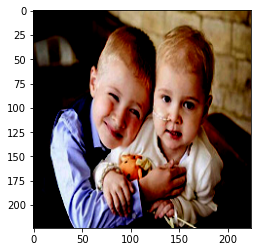

In [11]:
print(X_train[271])
plt.imshow(X_train[271])

Print the mask

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

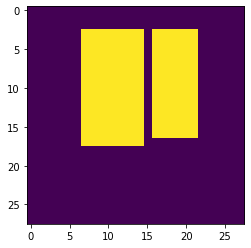

In [12]:
print(masks[27])
plt.imshow(masks[271])

## Create the model (7 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [13]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function (2 marks)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [14]:
model = create_model(False)

### Print model summary (2 marks)

In [15]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (3 marks)
- Create a function to calculate dice coefficient


In [16]:
def dice_coefficient(y_true,y_pred):
    numerator=2*tf.reduce_sum(y_true*y_pred)
    denominator=tf.reduce_sum(y_true+y_pred)
    
    return numerator/(denominator+tf.keras.backend.epsilon())

### Define loss function (3 marks)

In [17]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [18]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

### Define callbacks (3 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [19]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [20]:
model.fit(X_train, y_train, epochs = 20, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop])

Epoch 1/20
399/400 [============================>.] - ETA: 0s - loss: 2.0510 - dice_coefficient: 0.2748
Epoch 00001: loss improved from inf to 2.05307, saving model to model_2.05.h5
400/400 [==============================] - 12s 31ms/step - loss: 2.0531 - dice_coefficient: 0.2744
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 1.2959 - dice_coefficient: 0.4181
Epoch 00002: loss improved from 2.05307 to 1.29587, saving model to model_1.30.h5
400/400 [==============================] - 12s 31ms/step - loss: 1.2959 - dice_coefficient: 0.4181
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 1.1099 - dice_coefficient: 0.4771
Epoch 00003: loss improved from 1.29587 to 1.10987, saving model to model_1.11.h5
400/400 [==============================] - 13s 32ms/step - loss: 1.1099 - dice_coefficient: 0.4771
Epoch 4/20
399/400 [============================>.] - ETA: 0s - loss: 1.0251 - dice_coefficient: 0.5082
Epoch 00004: loss improved from 1.10987 to 1.

### Get the predicted mask for a test image   (3 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


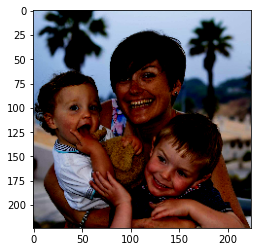

In [21]:
THRESHOLD = 0.8
EPSILON = 0.02
n = 0

unscaled = X_test[n]

image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
            cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2, x:x2] = 1

contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.imshow(unscaled)

Show original mask for test image

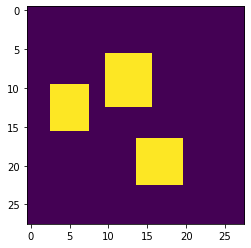

In [22]:
n = 0
sample_mask = y_test[n]

plt.imshow(sample_mask)

Predict the mask on the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


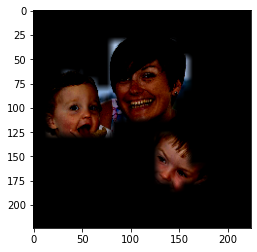

In [23]:
image = unscaled
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

### Impose the mask on the test image (3 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


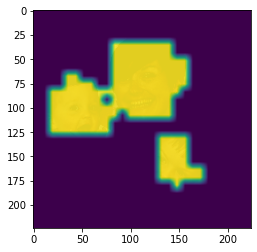

In [24]:
import matplotlib.pyplot as plt
out_image = image
plt.imshow(out_image)
plt.imshow(pred_mask, alpha=0.9)